### Analyze session data to derive rate estimations


In [1]:
# set a parameter to determine if outputs should be saved (prevents overwriting figures & csvs)
to_save = False

## TOC:
* [cleaningFunctions](#cleaningfunctions)
    


In [2]:
import pandas as pd
import datetime
import numpy as np
from scipy import stats #stats library
from scipy import optimize
import seaborn as sns; sns.set(color_codes=True) #plotting stuff
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm #regression stuff
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import locale
locale.setlocale(locale.LC_NUMERIC, '')

'en_US.UTF-8'


#### Cleaning functions <a class="anchor" id="cleaningfunctions"></a>
- load in data
- simplify & rename columns in df
- remove data which are > 10 std (compared to entire category)
- basic string cleaning
- setback field cleaning identification
- Known exception students to omit
    - multiple reasons for this

#### Load the dataset <a class="anchor" id="loaddata"></a>

In [3]:
usecolsList = ['Date', 'Student Name', 'Herbarium','Were there any setbacks? Please describe.',
            'Barcode application - number of specimens',
            'Barcode application - number of minutes spent',
            'Imaging - number of specimens', 'Imaging - number of minutes spent',
            'Skeletal data entry - number of specimens',
            'Skeletal data entry - number of minutes spent',
            'Pre-digitization curation - minutes spent',
            'Plant Mounting - number of minutes spent',
            'Imaging / Skeletal Data Entry Combined - number of minutes spent']

df = pd.read_csv('anonymized_task_data.csv', usecols = usecolsList, parse_dates=[0])
print(f'initial df shape: {df.shape}')
initial_size = df.shape[0]

initial df shape: (3360, 13)


#### Get a few initial pre-cleaning counts

In [4]:
# student names were anonmized using names from this source:
# https://memory-alpha.fandom.com/wiki/Category:Scientists

df['Student Name'].unique()

array(['Magnus Hansen', 'Icheb', 'Gilora Rejal', 'Theodore Wallace',
       'Samuel Estragon', 'Jannar', 'Carl Jaeger', 'Robert Johnson',
       'Juliana Tainer', 'Elizabeth Dehner', 'Robert Crater',
       'Jeff Carlson', 'Miklos Karlovassi', 'Janet Wallace', 'Luisa Kim',
       'Robert Jarvik', 'Andrus Hagan', 'Henry Archer', 'Elias Giger',
       "Miles O'Brien", 'Riley Frazier', 'Aleek-Om', 'Vash', "T'Pol",
       'Paul Stubbs', 'Kevin Uxbridge', 'Timicin', 'Terence Epstein',
       'Feezal Phlox', 'Samantha Wildman', 'Hannah Bates',
       "Keiko O'Brien", 'Noonian Soong', 'Mary Warren', 'Saru',
       'David Marcus', 'Arthur Malencon', 'Kila Marr', 'Paul Manheim',
       'Gabrielle Burnham', 'Mora Pol', 'John Gill', 'Gideon Seyetik',
       'Kathryn Janeway', 'Lewis Zimmerman', 'Carol Marcus',
       'Zefram Cochrane', 'Richard Daystrom', 'Anthony Haftel',
       'Nicolaus Copernicus', 'Nel Apgar', 'Elizabeth Cutler',
       'Harry Bernard', 'Pell Underhill', 'Roger Korby', 'Mike

In [5]:
display(f"total students: {len(df['Student Name'].unique())}")

minCols = ['Barcode application - number of minutes spent',
           'Imaging - number of minutes spent',
           'Skeletal data entry - number of minutes spent',
           'Pre-digitization curation - minutes spent',
           'Plant Mounting - number of minutes spent',
           'Imaging / Skeletal Data Entry Combined - number of minutes spent']

totMin = df[minCols].sum(numeric_only=True)
display(totMin)
totHours = round(totMin.sum() / 60, 0)
display(f"total hours spent: {totHours}'")

'total students: 107'

Barcode application - number of minutes spent                        74007.50
Imaging - number of minutes spent                                   149651.05
Skeletal data entry - number of minutes spent                       133587.19
Pre-digitization curation - minutes spent                            74099.00
Plant Mounting - number of minutes spent                             29324.00
Imaging / Skeletal Data Entry Combined - number of minutes spent      7775.00
dtype: float64

"total hours spent: 7807.0'"

#### determine pre-cleaning labor estimates for 3 primary digi tasks

In [6]:
prim_digi_minCols = ['Barcode application - number of minutes spent',
                     'Imaging - number of minutes spent',
                     'Skeletal data entry - number of minutes spent']

tot_prim_digi_Min = df[prim_digi_minCols].sum(numeric_only=True)
display(tot_prim_digi_Min)
tot_prim_digi_Hours = round(tot_prim_digi_Min.sum() / 60, 0)
display(f"total hours spent: {tot_prim_digi_Hours}'")

Barcode application - number of minutes spent     74007.50
Imaging - number of minutes spent                149651.05
Skeletal data entry - number of minutes spent    133587.19
dtype: float64

"total hours spent: 5954.0'"

#### Derive introduction statistics

In [7]:
specimen_cols = ['Barcode application - number of specimens',
                 'Imaging - number of specimens',
                 'Skeletal data entry - number of specimens']

spcols = df[specimen_cols].sum(numeric_only=True)
display(spcols)
display(f"total combined sp: {spcols.sum()}'")

Barcode application - number of specimens    263998.0
Imaging - number of specimens                308531.0
Skeletal data entry - number of specimens    345679.0
dtype: float64

"total combined sp: 918208.0'"

In [8]:
collections = df['Herbarium'].unique()

cols = ['Herbarium', 
        'total technicians',
        'total entries',
        'total specimens imaged', 
        'total hours imaging',
        'avg images per min',
        'total specimens databased', 
        'total hours databasing', 
        'avg database per min',
        'total specimens barcoded', 
        'total hours barcoding',
        'avg barcode per min']

coll_df = pd.DataFrame(columns=cols)

for coll in collections:
    temp_df = df.loc[df['Herbarium'] == coll].copy()

    tot_students = len(temp_df['Student Name'].unique())
    tot_entries = float(temp_df.shape[0])

    tot_sp_im = float(temp_df['Imaging - number of specimens'].sum())
    tot_min_im = temp_df['Imaging - number of minutes spent'].sum()
    tot_hr_im = round( tot_min_im/60, 1)
    avg_im = round (tot_sp_im / tot_min_im, 2)

    tot_sp_db = float(temp_df['Skeletal data entry - number of specimens'].sum())
    tot_min_db = temp_df['Skeletal data entry - number of minutes spent'].sum()
    tot_hr_db = round( tot_min_db/60, 1)
    avg_db = round (tot_sp_db / tot_min_db, 2)

    tot_sp_bc = float(temp_df['Barcode application - number of specimens'].sum())
    tot_min_bc = temp_df['Barcode application - number of minutes spent'].sum()
    tot_hr_bc = round( tot_min_bc/60, 1)
    avg_bc = round (tot_sp_bc / tot_min_bc, 2)

    data = [coll, tot_students, tot_entries,
            tot_sp_im, tot_hr_im, avg_im,
            tot_sp_db, tot_hr_db, avg_db,
            tot_sp_bc, tot_hr_bc, avg_bc]
    results = dict(zip(cols, data))

    #'Date'
    # assemble the data into a results then append it to coll_df

    coll_df = coll_df.append(results, ignore_index=True)

if to_save:
    coll_df.to_csv('collection_summary.csv', index=False)
coll_df

,Herbarium,total technicians,total entries,total specimens imaged,total hours imaging,avg images per min,total specimens databased,total hours databasing,avg database per min,total specimens barcoded,total hours barcoding,avg barcode per min
0,Middle Tennessee State University (MTSU),17,390.0,19438.0,229.2,1.41,73639.0,622.3,1.97,3348.0,23.4,2.39
1,Rhodes College (SWMT),5,92.0,5473.0,46.9,1.95,15789.0,112.3,2.34,4881.0,14.9,5.47
2,East Tennessee State University (ETSU),7,74.0,9841.0,58.5,2.81,4355.0,28.3,2.56,9861.0,39.8,4.13
3,"Berea College, Ralph L. Thompson Herbarium (BE...",7,113.0,22754.0,145.3,2.61,22105.0,92.1,4.00,51.0,0.1,6.38
4,University of Tennessee Chattanooga (UCHT),42,831.0,39997.0,397.9,1.68,34478.0,320.5,1.79,51351.0,285.3,3.00
5,University of Tennessee Knoxville (TENN),36,1572.0,195797.0,1407.9,2.32,175966.0,822.7,3.56,174118.0,729.8,3.98
6,Tennessee Technological University (HTTU),25,270.0,12658.0,187.6,1.12,15950.0,201.3,1.32,18053.0,131.1,2.30
7,University of the South Sewanee (UOS),3,3.0,423.0,2.4,2.92,661.0,3.8,2.94,525.0,1.7,5.25
8,University of Tennessee Martin (UT-M),2,15.0,2150.0,18.6,1.93,2736.0,23.2,1.96,1810.0,7.5,4.02


In [9]:
minCols = ['Barcode application - number of minutes spent',
           'Imaging - number of minutes spent',
           'Skeletal data entry - number of minutes spent']

group = df.groupby('Herbarium')

student_count = group.agg('Student Name').nunique().reindex()
groupdf = group[specimen_cols + minCols].sum(numeric_only=True).reindex()

groupdf['Participants'] = student_count
groupdf['Total Hours'] = round(groupdf[minCols].agg('sum', axis=1) / 60, 0).astype(int)
groupdf['Collection Code'] = groupdf.index.str.split('(').str[-1].str.replace(')', '')
groupdf['Collection'] = groupdf.index.str.split('(').str[0].str.replace(')', '')

keepcols = ['Collection', 'Collection Code', 'Participants', 'Total Hours'] + specimen_cols
groupdf = groupdf[keepcols]

if to_save:
    groupdf.to_csv('collection_summary.csv', index=False)

#### remove appropriate students* <a class="anchor" id="cleanstudents"></a>

In [10]:
rowCountBefore = df.shape[0] #check shape before removing students

#students that should be removed from consideration
StudentsToRemove = ['Lewis Zimmerman',
                     'Harry Bernard',
                     'Marla Aster',
                     'Tycho Brahe',
                     'Mortimer Harren',
                     'Timicin',
                     'Dekon Elig',
                     'Antoine Lavoisier',
                     'David Marcus',
                     'Theodore Wallace',
                     'Bruce Maddox']

# Antoine Lavoisier, and David Marcus have abnormally low variation.
# Theodore Wallace & Bruce Maddox have exceptionally poor rates after very high cumulative hours
#for student in StudentsToRemove:
problem_students = df[df['Student Name'].isin(StudentsToRemove)]
df = df[~df['Student Name'].isin(StudentsToRemove)]
rowCountAfter = df.shape[0]  #check shape after removing students
display(f'cleaning appropriate students dropped {rowCountBefore - rowCountAfter} rows')

'cleaning appropriate students dropped 337 rows'

In [11]:
totMin = problem_students[minCols].sum(numeric_only=True)
display(totMin)
totProblemStudentHours = round(totMin.sum() / 60, 0)

display(f"total problem hours: {totProblemStudentHours}")
display(f" or  {(totProblemStudentHours / totHours) * 100}% of total time spent")

Barcode application - number of minutes spent     9705.00
Imaging - number of minutes spent                20348.00
Skeletal data entry - number of minutes spent    25051.54
dtype: float64

'total problem hours: 918.0'

' or  11.758678109389011% of total time spent'

#### remove UOS <a class="anchor" id="cleanuos"></a>
- The workflow was drastically different

In [12]:
rowCountBefore = df.shape[0] #check shape before removing UOS
df = df[df['Herbarium'] != 'University of the South Sewanee (UOS)']
rowCountAfter = df.shape[0]  #check shape after removing UOS
display(f'cleaning UOS dropped {rowCountBefore - rowCountAfter} rows')

'cleaning UOS dropped 3 rows'

#### fill null values in numeric columns with 0 <a class="anchor" id="fillnull"></a>

In [13]:
df.columns

Index(['Date', 'Student Name', 'Herbarium',
       'Barcode application - number of specimens',
       'Barcode application - number of minutes spent',
       'Imaging - number of specimens', 'Imaging - number of minutes spent',
       'Skeletal data entry - number of specimens',
       'Skeletal data entry - number of minutes spent',
       'Pre-digitization curation - minutes spent',
       'Were there any setbacks? Please describe.',
       'Plant Mounting - number of minutes spent',
       'Imaging / Skeletal Data Entry Combined - number of minutes spent'],
      dtype='object')

In [14]:
df = df.fillna(0)
Columns_To_Clean = df.columns[3:].tolist() #pick each column after the first 3
Columns_To_Clean.remove('Were there any setbacks? Please describe.')
for col in Columns_To_Clean:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.replace([np.inf, -np.inf], 0)

df.dtypes # check the resulting data types

Date                                                                datetime64[ns]
Student Name                                                                object
Herbarium                                                                   object
Barcode application - number of specimens                                  float64
Barcode application - number of minutes spent                              float64
Imaging - number of specimens                                              float64
Imaging - number of minutes spent                                          float64
Skeletal data entry - number of specimens                                  float64
Skeletal data entry - number of minutes spent                              float64
Pre-digitization curation - minutes spent                                  float64
Were there any setbacks? Please describe.                                   object
Plant Mounting - number of minutes spent                                   float64
Imag

#### Clean up misc. errors detected <a class="anchor" id="cleanmisc"></a>

In [15]:
rowCountBefore = df.shape[0] #check shape before removing misc. errors

# when chaning forms early on, a few artifacts were generated
#removing them
df = df[~((df['Skeletal data entry - number of minutes spent'] > 10) & (df['Skeletal data entry - number of specimens'] < 2))]

# E. Poindexter has two probably incorrect entries, both with: 300 mintutes @ 8 specimens databased
# removing them
df = df[~((df['Skeletal data entry - number of minutes spent'] > 60) & (df['Skeletal data entry - number of specimens'] < 10))]

# Approx 7 entries of transposed database values detected, all more than 3.5 min per specimen
# removing them

# keep the 'bad stuff' to look at
transposed_df = df[((df['Skeletal data entry - number of minutes spent'])  >  (3.5 * (df['Skeletal data entry - number of specimens'])))]

df = df[~((df['Skeletal data entry - number of minutes spent'])  >  (3.5 * (df['Skeletal data entry - number of specimens'])))]

# ensure the entries are sequentially ordered.
df = df.sort_values(by = 'Date')

rowCountAfter = df.shape[0]  #check shape after cleaning misc. errors
display(f'cleaning misc. errors dropped {rowCountBefore - rowCountAfter} rows')


'cleaning misc. errors dropped 36 rows'

#### Clean "setbacks" field *Possibly worth reconsidering <a class="anchor" id="cleansetbacks"></a>

In [16]:
# define, and apply a string cleaner which helps to normalize data in the setbacks fields
def cleanString(dirtyString):
    try:
        dirtyString = str(dirtyString)
        cleanedString = dirtyString.replace('.','').strip().lower()
        return cleanedString
    except:
        return dirtyString

df['Were there any setbacks? Please describe.'].apply(cleanString)

rowCountBefore = df.shape[0] #check shape before removing setbacks
acceptedList = [0,np.nan,'no','nope','none', 'none.','','n/a','0','no setbacks','no set backs','no major setbacks','no  major setbacks.']

# segment a dataframe containing the to-be-removed setbacks data
setBackDF = df[~df['Were there any setbacks? Please describe.'].str.lower().str.strip().isin(acceptedList)] 

# restrict df to only those with "Acceptable" setback terms (e.g., those in acceptedList)
df = df[df['Were there any setbacks? Please describe.'].str.lower().str.strip().isin(acceptedList)]

# drop the setbacks field to simplify further analysis
df = df.drop(columns=['Were there any setbacks? Please describe.'])
df.fillna(0,inplace = True)

rowCountAfter = df.shape[0]  #check shape after removing setbacks
display(f'cleaning setbacks dropped {rowCountBefore - rowCountAfter} rows')

'cleaning setbacks dropped 453 rows'

#### Analyze the segmented setbacks data

In [17]:
from collections import Counter
import nltk
from nltk.corpus import stopwords


setbacks = setBackDF['Were there any setbacks? Please describe.'].tolist()
corpus = []
for setback in setbacks:
    corpus += setback.lower().split()

# define words not worth counting (e.g., 'the', 'and', 'so' .. etc)
stop_words = set(x.lower() for x in stopwords.words('english'))
# remove stopwords, numbers and words containing less than 4 letters
corpus = [w for w in corpus if (not w in stop_words) and (not w.isnumeric()) and (len(w) > 3)] 
# Store the frequency counts of the remaining words.
counts =  Counter(corpus)

# display the top n most frequent words
display(counts.most_common(50))

[('training', 51),
 ('sernec', 43),
 ('specimen', 39),
 ('data', 33),
 ('time', 31),
 ('skeletal', 31),
 ('specimens', 29),
 ('entry', 26),
 ('slow', 25),
 ('major', 17),
 ('case,', 17),
 ('imaging', 15),
 ('folders', 14),
 ('computer', 14),
 ('back', 14),
 ('label', 14),
 ('mins', 13),
 ('missing', 13),
 ('first', 13),
 ('also', 13),
 ('went', 12),
 ('times', 12),
 ('spent', 11),
 ('camera', 11),
 ('minutes', 11),
 ('setting', 11),
 ('collector', 11),
 ('repair', 11),
 ('working', 10),
 ('barcodes', 10),
 ('took', 10),
 ('lots', 10),
 ('many', 10),
 ('kept', 10),
 ('species', 9),
 ('work', 9),
 ('internet', 9),
 ('mounting', 9),
 ('connection', 9),
 ('name', 9),
 ('station', 8),
 ('blitz', 8),
 ('server', 8),
 ('barcode', 7),
 ('lagging', 7),
 ('entered', 7),
 ('order', 7),
 ('mixed', 7),
 ('scanner', 7),
 ('dropping', 7)]

#### Generate a wordcloud for setbacks

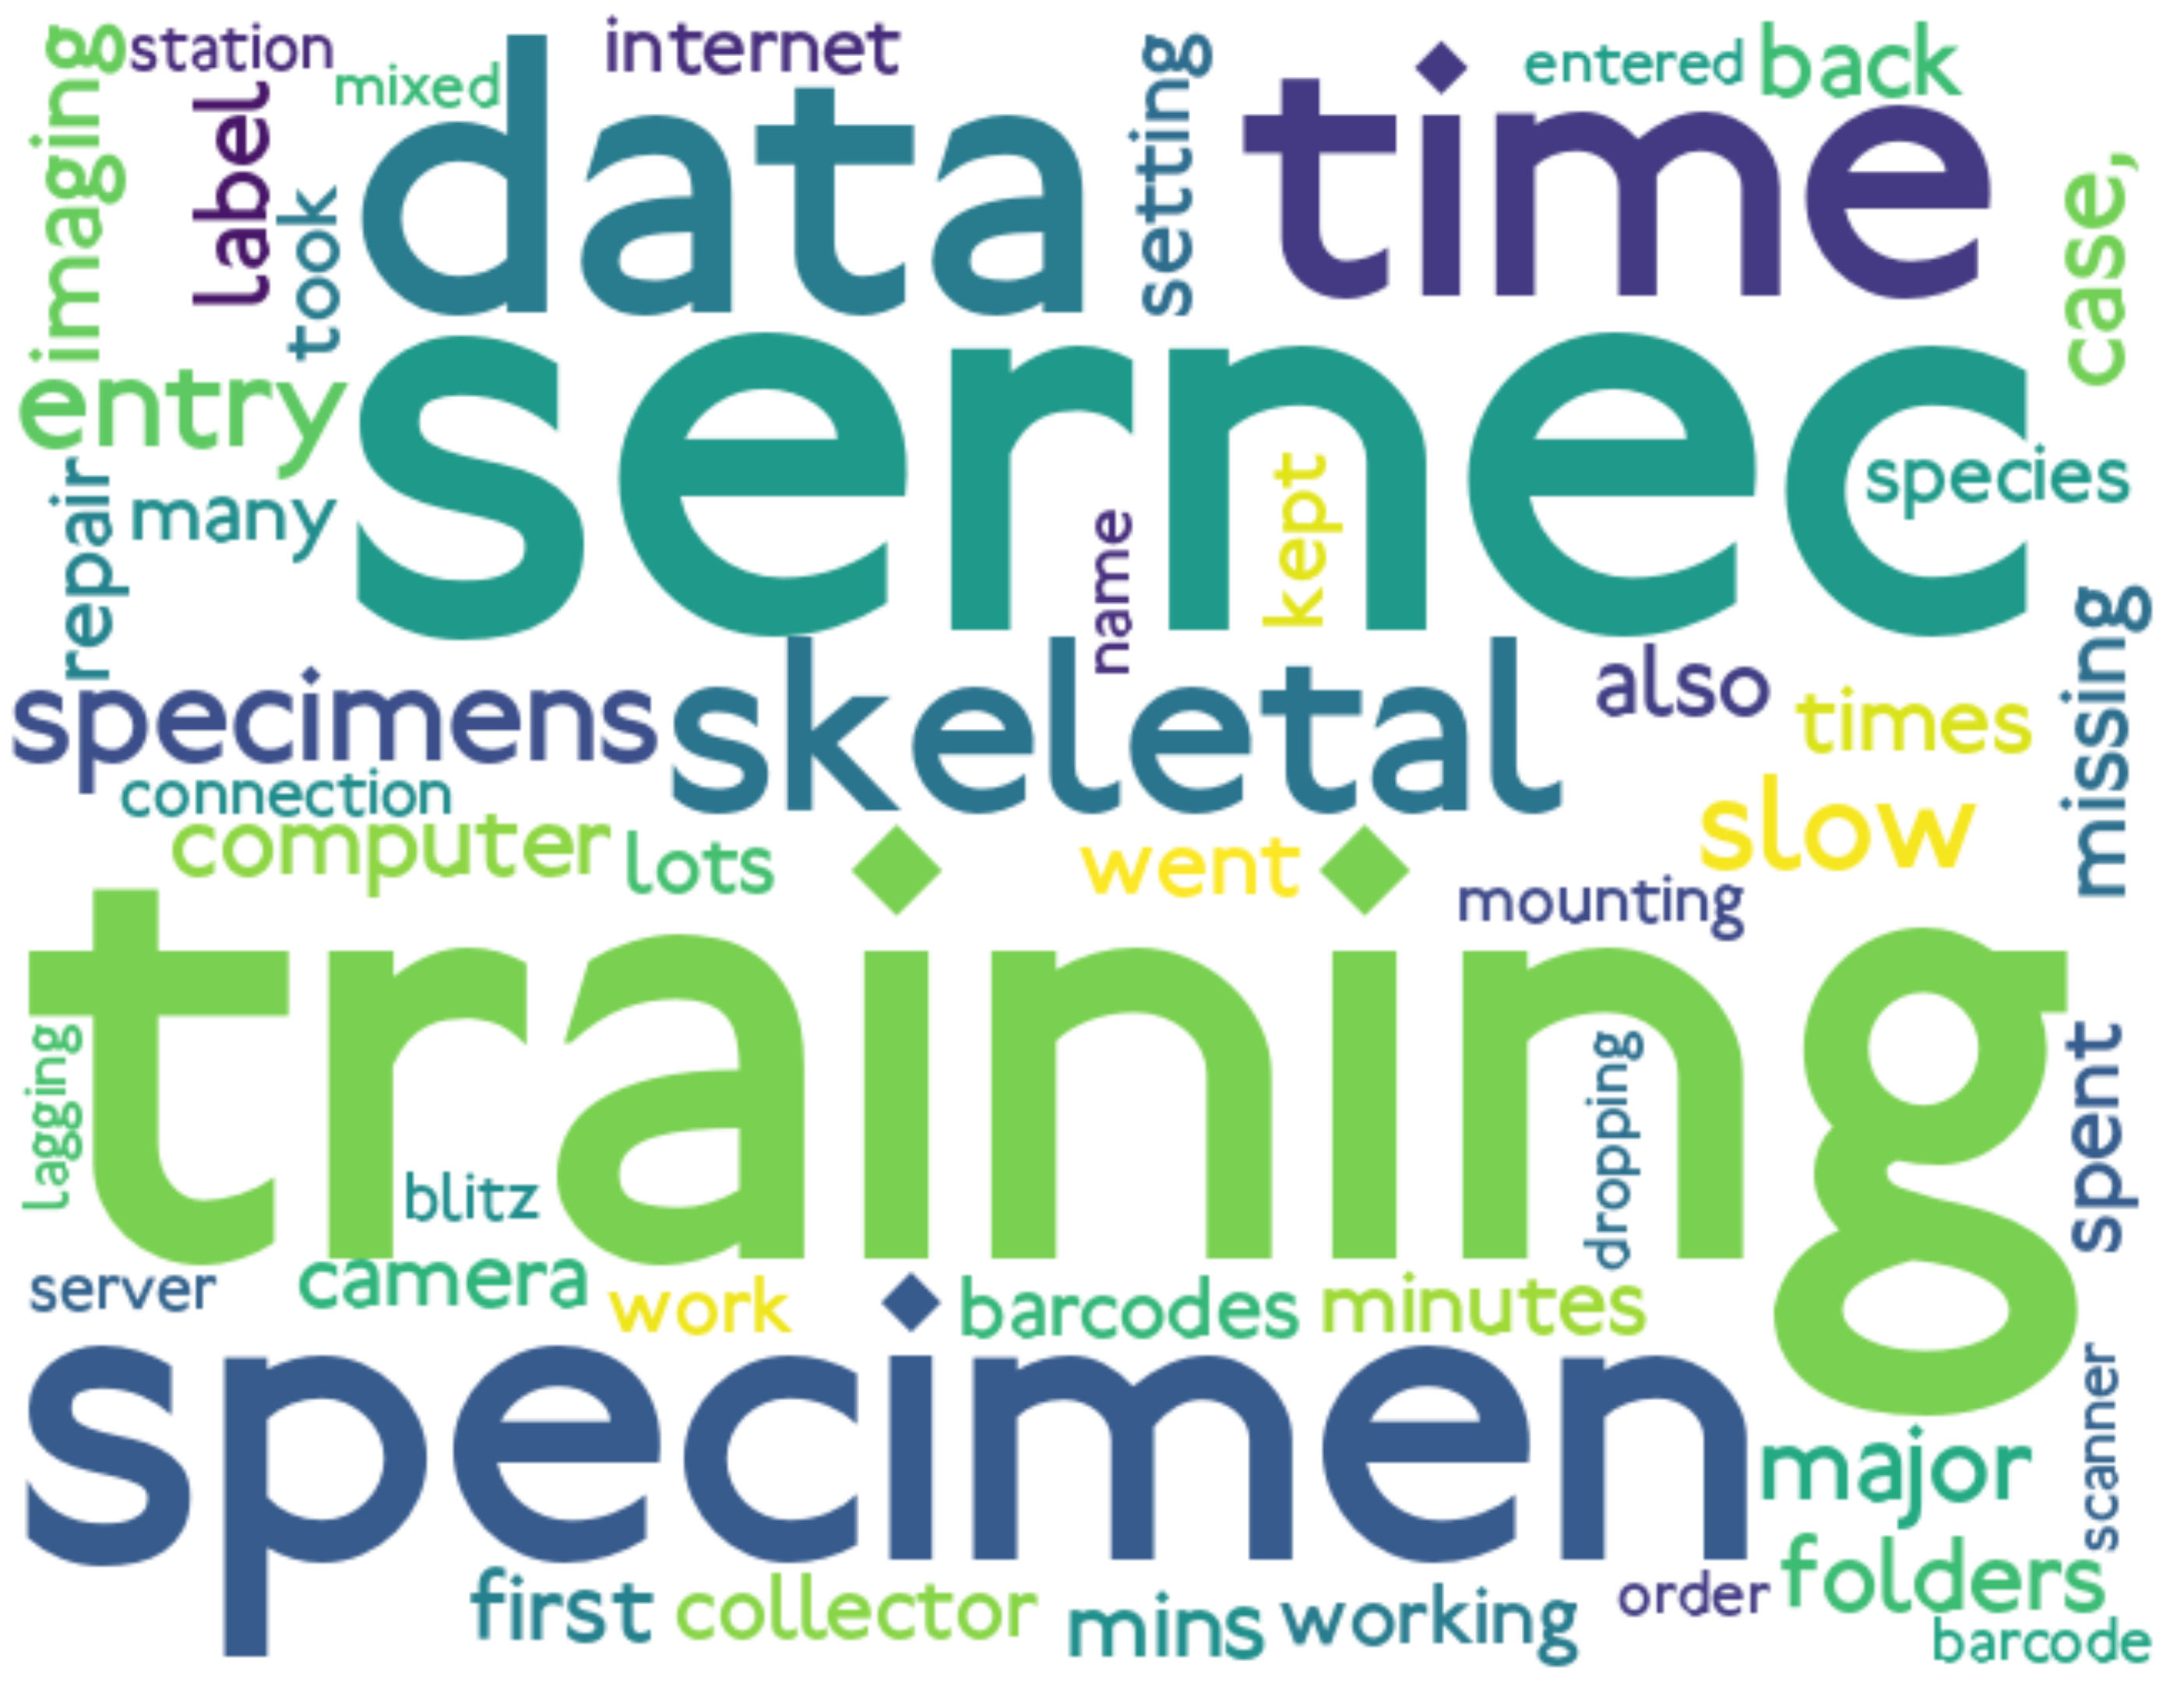

In [18]:
from wordcloud import WordCloud, ImageColorGenerator
set_back_freq = {i:j for i, j in (counts.most_common(50))}

fontPath = "/usr/share/fonts/OTF/Railway.otf"
wc = WordCloud(background_color='white', 
               height=500, width=650,
              prefer_horizontal=0.7,
              #max_font_size=36,
              font_path=fontPath)

wc.generate_from_frequencies(set_back_freq)

plt.figure(figsize=(50, 65))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
# Quantify the time spent per task when a non-acceptable setback was indicated

tot_setbacks = len(setBackDF)

minCols = ['Barcode application - number of minutes spent',
           'Imaging - number of minutes spent',
           'Skeletal data entry - number of minutes spent']

sumSetBacks = setBackDF[minCols].sum(numeric_only=True).sum()
display(sumSetBacks)
tot_setback_Hours = round(sumSetBacks / 60, 0)
display(f"total hours associated with a setback: {tot_setback_Hours}'")

56762.15

"total hours associated with a setback: 946.0'"

In [20]:
totMin = setBackDF[minCols].sum(numeric_only=True)
display(totMin)
totSetBackHours = round(totMin.sum() / 60, 0)
display(f"total quantity of setbacks: {len(setBackDF)}")
display(f"total setbacks: {totSetBackHours}")
display(f" or  {(totSetBackHours / totHours) * 100}% of total time spent")

Barcode application - number of minutes spent    12886.00
Imaging - number of minutes spent                21219.00
Skeletal data entry - number of minutes spent    22657.15
dtype: float64

'total quantity of setbacks: 453'

'total setbacks: 946.0'

' or  12.117330600742923% of total time spent'

#### Assess the mean duration of set back sessions

In [21]:
tot_tasks = ['Skeletal data entry - number of minutes spent',
             'Imaging - number of minutes spent',
            'Barcode application - number of minutes spent']

# get mean session duration accross all tasks
tot_mean_task = pd.concat(setBackDF[x] for x in tot_tasks)
display(tot_mean_task.shape)
display(tot_mean_task.replace(0, np.nan).mean(skipna=True))
# get mean session duration for each task
for task in tot_tasks:
    display(task)
    mean_task = setBackDF[task].replace(0, np.nan).mean(skipna=True)
    display(mean_task)

(1359,)

133.2444835680751

'Skeletal data entry - number of minutes spent'

121.16122994652407

'Imaging - number of minutes spent'

143.3716216216216

'Barcode application - number of minutes spent'

141.6043956043956

#### Clean outliers which are > 5 std  <a class="anchor" id="cleanoutliers"></a>

In [22]:
# first modify the usecolsList to inclue only those cols appropriate for outlier analysis
for itemToRemove in ['Timestamp','Herbarium','Your Name','Were there any setbacks? Please describe.',
                    'Imaging / Skeletal Data Entry Combined - number of minutes spent',
                    'Pre-digitization curation - minutes spent',
                    'Plant Mounting - number of minutes spent']:
    try:
        usecolsList.remove(itemToRemove)
    except:
        pass

rowCountBefore = df.shape[0] #check shape before removing outliers
for cat in usecolsList:
    print(cat)  #print which columns were cleaned.
    if np.issubdtype(df[cat].dtype, np.number):
        threshold = 5
        a = (threshold*df[cat].std())
        df = df[(df[cat] < a) | (df[cat].isna())].copy(deep = True)
rowCountAfter = df.shape[0]  #check shape after removing outliers

display(f'cleaning >5 std dropped: {rowCountBefore - rowCountAfter} rows')

Date
Student Name
Barcode application - number of specimens
Barcode application - number of minutes spent
Imaging - number of specimens
Imaging - number of minutes spent
Skeletal data entry - number of specimens
Skeletal data entry - number of minutes spent


'cleaning >5 std dropped: 82 rows'

#### Assess what is left after the cleaning

- totHours is orig max hours for all tasks before any cleaning
- tot_hours is the total hours evaluated in the rate analysis. That is, after cleaning and only img, bc, db tasks.

In [23]:
tot_cleaned_rows = initial_size - df.shape[0]
display(f'total cleaned rows = {tot_cleaned_rows}')
display(f'total remaining rows = {df.shape[0]}')

'total cleaned rows = 911'

'total remaining rows = 2449'

In [24]:
minCols = ['Barcode application - number of minutes spent',
           'Imaging - number of minutes spent',
           'Skeletal data entry - number of minutes spent',
           'Pre-digitization curation - minutes spent',
           'Plant Mounting - number of minutes spent',
           'Imaging / Skeletal Data Entry Combined - number of minutes spent']

totMin = df[minCols].sum(numeric_only=True)
tot_cleaned_Hours = round(totMin.sum() / 60, 0)
display(f"total hours spent post cleaning: {tot_cleaned_Hours}")
display(f"total % hours cleaned out: {(1 - (tot_cleaned_Hours / totHours))* 100}%")
display(f"total hours cleaned NOT SETBACK: { totHours - tot_cleaned_Hours}")

'total hours spent post cleaning: 5023.0'

'total % hours cleaned out: 35.66030485461765%'

'total hours cleaned NOT SETBACK: 2784.0'

In [25]:
df.columns

Index(['Date', 'Student Name', 'Herbarium',
       'Barcode application - number of specimens',
       'Barcode application - number of minutes spent',
       'Imaging - number of specimens', 'Imaging - number of minutes spent',
       'Skeletal data entry - number of specimens',
       'Skeletal data entry - number of minutes spent',
       'Pre-digitization curation - minutes spent',
       'Plant Mounting - number of minutes spent',
       'Imaging / Skeletal Data Entry Combined - number of minutes spent'],
      dtype='object')

#### Assess the mean duration of non-set back sessions

In [26]:
tot_tasks = ['Skeletal data entry - number of minutes spent',
             'Imaging - number of minutes spent',
            'Barcode application - number of minutes spent']

tot_sp_cts = ['Skeletal data entry - number of specimens',
              'Imaging - number of specimens',
              'Barcode application - number of specimens']

# get mean session duration accross all tasks
tot_mean_task = pd.concat(df[x] for x in tot_tasks)
display(tot_mean_task.shape)
display(tot_mean_task.replace(0, np.nan).mean(skipna=True))
# get mean session duration for each task
for task in tot_tasks:
    display(task)
    mean_task = df[task].replace(0, np.nan).mean(skipna=True)
    display(f'mean task: {mean_task}')
    
for task in tot_sp_cts:
    display(task)
    sum_task = df[task].sum()
    display(f'total specimens: {sum_task}')

(7347,)

100.89699085219065

'Skeletal data entry - number of minutes spent'

'mean task: 96.55563186813187'

'Imaging - number of minutes spent'

'mean task: 111.6520809248555'

'Barcode application - number of minutes spent'

'mean task: 88.2055785123967'

'Skeletal data entry - number of specimens'

'total specimens: 223128.0'

'Imaging - number of specimens'

'total specimens: 223714.0'

'Barcode application - number of specimens'

'total specimens: 175508.0'

In [27]:

tot_db = sum(df['Skeletal data entry - number of minutes spent'])

tot_tasks = ['Skeletal data entry - number of minutes spent',
             'Imaging - number of minutes spent',
            'Barcode application - number of minutes spent']

tot_task_min = 0
for task in tot_tasks:
    tot_task_min += sum(df[task])

for task in tot_tasks:
    display(task)
    min_task = sum(df[task])
    pct_task = round((min_task / tot_task_min)*100, 4)

    hr_task = round((min_task / 60), 2)
    display(f'pct_task = {pct_task}')
    display(f'hr_task = {hr_task}')


'Skeletal data entry - number of minutes spent'

'pct_task = 33.5424'

'hr_task = 1171.54'

'Imaging - number of minutes spent'

'pct_task = 46.0859'

'hr_task = 1609.65'

'Barcode application - number of minutes spent'

'pct_task = 20.3717'

'hr_task = 711.52'

In [28]:
primary_dig_task_hours = sum(df[tot_tasks].sum())
print(f'total hours tracked on primary digitization = {round(primary_dig_task_hours / 60, 2)}')
# print the total removed rows after cleaning
print(f"cleaning removed: {initial_size - df[tot_tasks].shape[0]} rows")

total hours tracked on primary digitization = 3492.72
cleaning removed: 911 rows


In [29]:
hr_db = round(tot_db / 60, 2)
hr_db

1171.54

In [30]:
sp_db = sum(df['Skeletal data entry - number of specimens'])
sp_db

223128.0

In [31]:
hr_task = round(tot_task_min / 60, 2)

In [32]:
pct_db = hr_db / hr_task

In [33]:
pct_db

0.33542339494720447

## Analysis by student <a class="anchor" id="analysisbystudent"></a>

Aggregate statistics by student

In [34]:
# simply some column names with variables
bc_Num = 'Barcode application - number of specimens'
bc_Time = 'Barcode application - number of minutes spent'
img_Num = 'Imaging - number of specimens'
img_Time = 'Imaging - number of minutes spent'
db_Num = 'Skeletal data entry - number of specimens'
db_Time = 'Skeletal data entry - number of minutes spent'

df['bc_Rate'] = df[bc_Num] / df[bc_Time]                 #Add a barcode Rate for that single entry
df['img_Rate'] = df[img_Num] / df[img_Time]              #Add an imaging Rate for that single entry
df['db_Rate'] = df[db_Num] / df[db_Time]                 #Add a database Rate for that single entry

studentGroupBy = df.groupby('Student Name') #var for a single student

cumulCatList = []
for category in [bc_Time,img_Time,db_Time]:     #For each unique student in the list, generate time cumulsums per task
    cumulCatName = category + '_Cumulative'
    df[cumulCatName] = studentGroupBy[category].cumsum()
    cumulCatList.append(cumulCatName)

df['total_Cumulative_Times'] = df.apply(lambda row: row[cumulCatList].sum(), axis=1) #first add that row's combined time
df['total_Cumulative_Times'] = studentGroupBy['total_Cumulative_Times'].cumsum() #then cumul sum it in student groupby

for category in [bc_Num, img_Num, db_Num]:     #For each unique student in the list, generate specimen cumulsums per task
    cumulCatName = category + '_Cumulative'
    df[cumulCatName] = studentGroupBy[category].cumsum()
    cumulCatList.append(cumulCatName)

expandingCatList = []
#For each unique student in the list, gen expanding mean and cumulsums    
for category, minInCat in {'bc_Rate':bc_Time,
                           'img_Rate':img_Time,
                           'db_Rate':db_Time}.items():
    # select only those rows which had new data added to that category.
    
    expMeanCatName = category + '_Expanding_Mean'
    df[expMeanCatName] = np.nan
    
    for student in df['Student Name'].unique():
        # only fill in expanding means when new data has been made for that student in that category.
        subsetDF = df[(df['Student Name'] == student) & df[minInCat] > 0].copy(deep=True)
        # require 2 entries before calculating the rate expanding mean.
        subsetDF[expMeanCatName] = subsetDF[category].expanding(2).mean()
        df.fillna(subsetDF, inplace=True)

    #maintain a list of expanded mean category names.
    expandingCatList.append(expMeanCatName)

# Clean out the infinates
df = df.replace([np.inf, -np.inf], np.nan)

In [35]:
df.shape

(2449, 25)

In [36]:
df.columns

Index(['Date', 'Student Name', 'Herbarium',
       'Barcode application - number of specimens',
       'Barcode application - number of minutes spent',
       'Imaging - number of specimens', 'Imaging - number of minutes spent',
       'Skeletal data entry - number of specimens',
       'Skeletal data entry - number of minutes spent',
       'Pre-digitization curation - minutes spent',
       'Plant Mounting - number of minutes spent',
       'Imaging / Skeletal Data Entry Combined - number of minutes spent',
       'bc_Rate', 'img_Rate', 'db_Rate',
       'Barcode application - number of minutes spent_Cumulative',
       'Imaging - number of minutes spent_Cumulative',
       'Skeletal data entry - number of minutes spent_Cumulative',
       'total_Cumulative_Times',
       'Barcode application - number of specimens_Cumulative',
       'Imaging - number of specimens_Cumulative',
       'Skeletal data entry - number of specimens_Cumulative',
       'bc_Rate_Expanding_Mean', 'img_Rate_Ex

In [37]:
bc_hours = df['Barcode application - number of minutes spent'].sum()
im_hours = df['Imaging - number of minutes spent'].sum()
db_hours = df['Skeletal data entry - number of minutes spent'].sum()

tot_hours = bc_hours + im_hours + db_hours
tot_hours = round(tot_hours / 60, 0)
tot_hours

3493.0

In [38]:
display(f"Post cleaning: {len(df['Student Name'].unique())} students remain")
len(df['Student Name'].unique())
# student names were anonmized using names from this source:
# https://memory-alpha.fandom.com/wiki/Category:Scientists
print("the students remaining are: ")
df['Student Name'].unique()

'Post cleaning: 94 students remain'

the students remaining are: 


array(['Terence Epstein', 'Kes', 'Seska', 'Hal Moseley', 'Tolen Ren',
       'Rishon Uxbridge', 'Richard Galen', 'Stavos Keniclius',
       'Leila Kalomi', 'Ulani Belor', 'Christine Chapel',
       'Jean-Luc Picard', 'Emory Erickson', 'Beverly Crusher',
       'Mary Warren', 'Saavik', 'Lawrence Marvick', 'Howard Clark',
       'Theodore Haskins', 'Rain Robinson', 'John Burke',
       'Samantha Wildman', 'Pell Underhill', 'Robert Johnson',
       'Pran Tainer', 'Gillian Taylor', 'Randi Bryce', 'Ira Graves',
       'Elias Giger', 'Deanna Troi', 'Forra Gegen', 'Kevin Uxbridge',
       'Surmak Ren', 'Michael Burnham', 'Montgomery Scott', 'Airiam',
       'Irina Galliulin', 'Helen Noel', 'Mike Burnham', 'Kathryn Janeway',
       'Janet Wallace', 'Feezal Phlox', 'Saru', "Keiko O'Brien",
       'John Gill', 'Nel Apgar', 'Gideon Seyetik', 'Elizabeth Cutler',
       'Carol Marcus', 'Hannah Bates', 'Richard Daystrom',
       'Zefram Cochrane', 'Anthony Haftel', 'Nicolaus Copernicus',
       'Kil

#### Generalize each institution's input post cleaning

In [39]:
# Generate a DF with binned hours all rates and expanded mean of rates.

#get dict of the columns to add into the plotting df, associate the columns with their respective rates
colsOfInterest = {'Barcode application - number of minutes spent_Cumulative':
                  ['Barcode application - number of specimens_Cumulative','bc_Rate','bc_Rate_Expanding_Mean'],
                'Imaging - number of minutes spent_Cumulative':
                  ['Imaging - number of specimens_Cumulative','img_Rate','img_Rate_Expanding_Mean'],
                'Skeletal data entry - number of minutes spent_Cumulative':
                  ['Skeletal data entry - number of specimens_Cumulative','db_Rate','db_Rate_Expanding_Mean']}

nEntriesDict = {}
totHrsDict = {}
def splitDF(inDF, category, toBin=False, agg=True):
    """inDF is the source database from which the category is split out of.
    category is the interested category, which will be split out of the inDF 
    toBin, Boolean value determining if the timesplit should be split into descrete bins of 2 hours.
    agg, Boolean value determining if the resulting df should be aggregated by student names."""
    
    tempDF = pd.DataFrame()
    tempDF['Student Name'] = inDF['Student Name']
    
    keyName = category.split('_Cumulative')[0]
    nEntriesDict[category] = len(inDF[inDF[keyName] > 1])
    totHrsDict[category] = int(inDF.groupby('Student Name')[category].max().agg(sum) / 60)
    
    binSize = 2 # the size of each hourly bin
    
    if toBin:
        # generate a df using the desired bins as the index.
        bins = np.arange(0,100,binSize)
        binLabels = list(range(binSize, 100, binSize))
        tempDF[category] = pd.cut(inDF[category]/60, bins, labels=binLabels)
    else:
        tempDF[category] = inDF[category] / 60
    for item in colsOfInterest.get(category):
        Item = inDF[item]
        tempDF = pd.concat([tempDF,Item], axis = 1)
    tempDF = tempDF.dropna()
    tempDF.rename(columns={category:'Hours'}, inplace=True)
    name, hours, specimen, rate, expMean = tempDF.columns # Fragile name assignment!
    
    tempDF.sort_values(by=[hours], inplace=True)
    tempDF[hours] = tempDF[hours].astype(int) # converting this to an integer effectivly makes it a bin.
    
    tempDF.rename(columns={specimen:'Specimen_Qty'}, inplace=True)
    tempDF.reset_index(drop = True, inplace=True)
    if toBin: #if binned, transform the calculated columns to reflect the bin
        grouped = tempDF.groupby([name, hours])
        tempDF[rate] = grouped[rate].transform('mean')
        #tempDF[expMean] = grouped[expMean].transform('max') #not applicable if binning
        ######################################################
    if agg: # if aggregated, transform the calculated columns to the means of each group
        grouped = tempDF.groupby(hours)
        tempDF[rate] = grouped[rate].transform('mean')
        tempDF[expMean] = grouped[expMean].transform('mean')
        tempDF = tempDF.drop(name,1)
    tempDF.drop_duplicates([rate, expMean], inplace = True) #drop the duplicated rows
    return tempDF

bcDF = splitDF(df,'Barcode application - number of minutes spent_Cumulative',toBin = True, agg = False)
imDF = splitDF(df,'Imaging - number of minutes spent_Cumulative',toBin = True, agg = False)
dbDF = splitDF(df,'Skeletal data entry - number of minutes spent_Cumulative',toBin = True, agg = False)  
tasks=[bcDF,imDF,dbDF]


3.7216 + 0.09928x -0.00175x^2


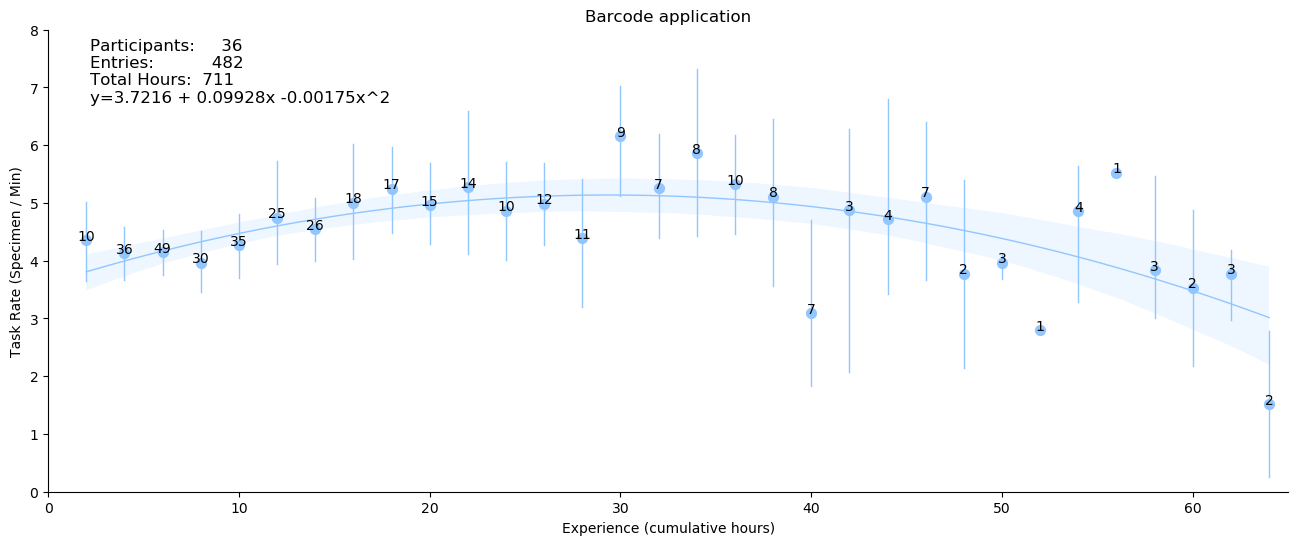

1.95170 + 0.02118x


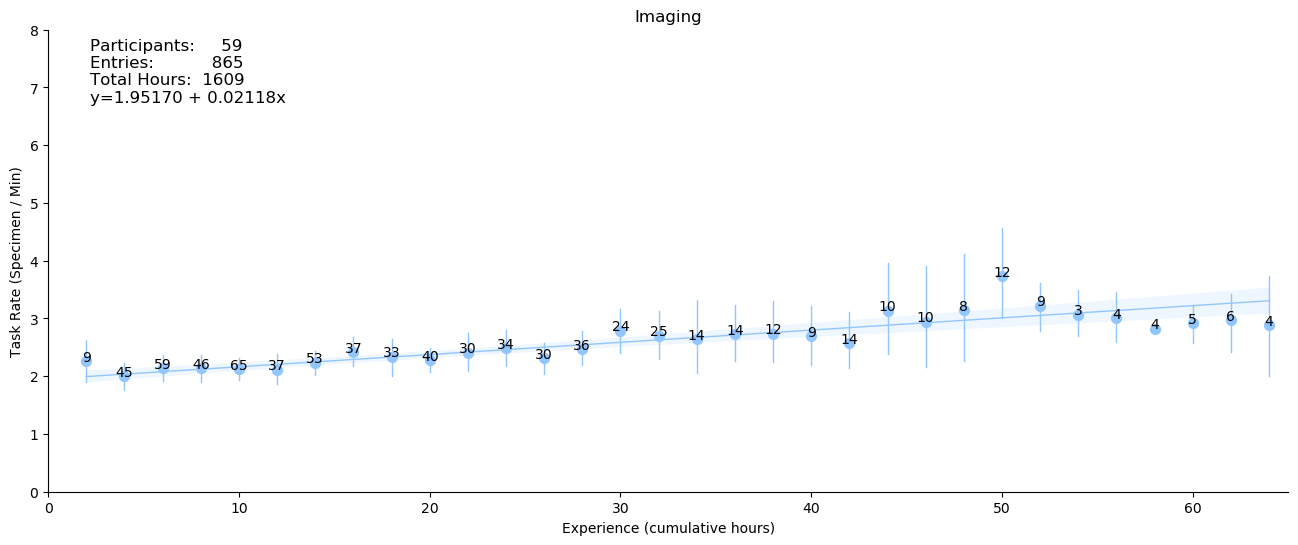

2.55659 + 0.02760x


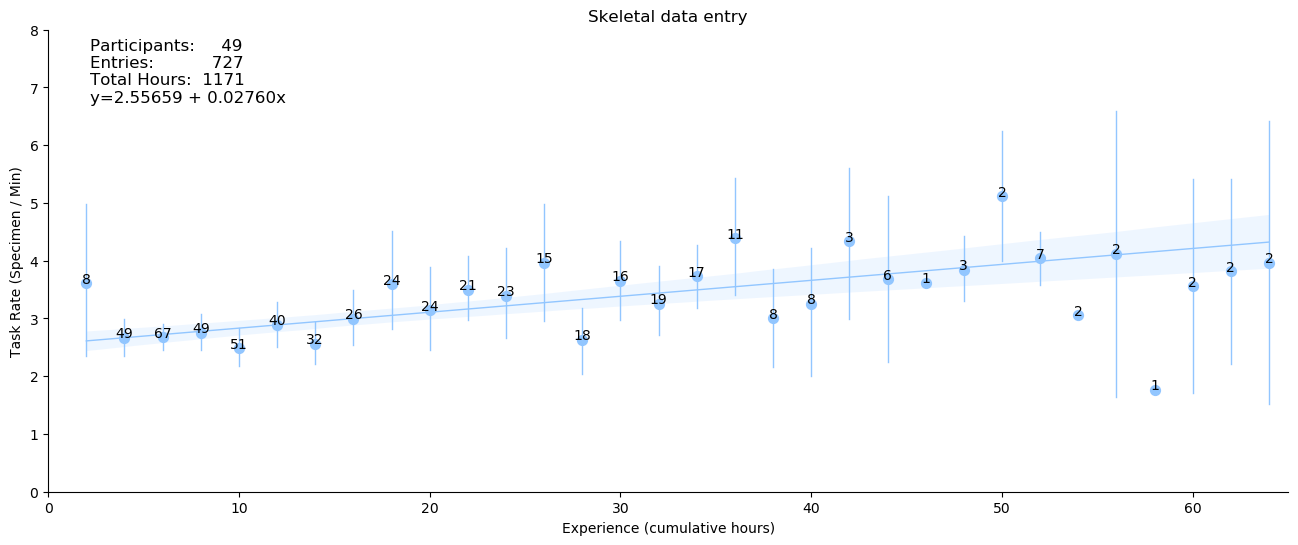

In [40]:
mpl.rcParams.update(mpl.rcParamsDefault)

x = 0
tasks={'Barcode application':bcDF,
       'Imaging':imDF,
       'Skeletal data entry':dbDF}

ylab = 'Task Rate (Specimen / Min)'
xlab = 'Experience (cumulative hours)'
maxHours = 65

for title, task in tasks.items():
    taskKey = f'{title} - number of minutes spent_Cumulative'
    pltlab = title
    
    plt.style.use('seaborn-pastel')
    plt.figaspect
    x = x + 1
    name, hours, specimen, rate, expMean = task.columns # Fragile name assignment!
    xVar = hours
    yVar = rate
    
    limitedTask = task[(task[hours] >= 1) & (task[hours] <= maxHours) ].copy(deep=True)  #remove 1 offs and oddballs
    # limit the consideration to those students which have a min entries for that task.
    #NOTE IF Binning, the entry limit is reduced by bins
    taskThreshold = 2
    limitedTask = limitedTask[limitedTask[name].isin(limitedTask[name].value_counts()[limitedTask[name].value_counts()>taskThreshold].index)]

    if title == 'Barcode application':
        # barcoding seems to be a 2nd order polynomial.
        orderOfLine = 2
        g = sns.regplot(x= xVar, y=yVar, data=limitedTask, x_estimator=np.mean, 
                        order= orderOfLine, truncate= True)

        # Calculate the formula values because seaborn is too 'high brow' to provide them.
        import numpy.polynomial.polynomial as poly
        xArr = limitedTask[hours].unique()
        yArr = limitedTask.groupby('Hours').agg(['mean'])[rate]['mean'].values
        coefs = poly.polyfit(xArr, yArr, orderOfLine)
        c1, c2, c3 = coefs

        #prep the formula annotation text.
        coefList = []
        for i, c in enumerate(coefs):
            # formula really needs atleeast 4 places to be accurate out to ~ 60 hours.
            c = round(c, 5)
            if c < 0 or i == 0:
                txt = f'{c}'
            else:
                txt = f'+ {c}'
            if i > 0:
                txt = txt + 'x'
            if i > 1:
                txt = txt + (f'^{i}')

            coefList.append(txt)
        formula = ' '.join(coefList)
    else:
        # if it is not barcode, fit it to a linear model.
        g = sns.regplot(x= xVar, y=yVar, data=limitedTask, x_estimator=np.mean, truncate= True)
        slope, intercept, r_value, p_value, std_err = stats.linregress(limitedTask[xVar],limitedTask[yVar])
        formula = '{:.5f} + {:.5f}x'.format(intercept, slope)

    nPeople = len(limitedTask[name].unique())
    nEntries = nEntriesDict.get(taskKey)
    totHrs = totHrsDict.get(taskKey)

    g.figure.set_size_inches(16,6)
    g.set_ylabel(ylab)
    g.set_xlabel(xlab)
    g.set_title(pltlab)
    g.annotate('\nParticipants:     {}\nEntries:           {}\nTotal Hours:  {}\ny={}'.format(nPeople, nEntries, totHrs, formula),
                xy=(.02, 1.05), xytext=(12, -10), va='top',
                 xycoords='axes fraction', textcoords='offset points', fontsize=12)
    plt.setp(g.lines,linewidth=1)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    plt.ylim(0,8)
    plt.xlim(0,maxHours)

    studentCounts = limitedTask.groupby('Hours').agg(['count'])
    studentCounts = studentCounts[rate]['count']

    for i, count in studentCounts.items():
        g.annotate(count, (i, limitedTask.loc[limitedTask[xVar] == i][yVar].mean()), ha="center")
    print(formula)
    if to_save:
        plt.savefig(f'{title}-student-mean.png')
    plt.show()

#### Use the derived models to make estimates

Simulations prohibit the models from predicting beyond the reasonable limits.
 - Barcoding limit is less than 3 specimens per minute
 - Imaging limit is greater than 4 specimens per minute
 - Databasing limit is greater than 6.5 specimens per minute
 
General process for this simulation is illustrated in publication as:
<img src="rate_simulation_flow.png">

In [41]:
# Define functions for each model orig models

def calcBCRate(x):
    bcRate = (3.7216) + (0.09928*x) - (0.00175)*(x**2)
    #  set a floor
    if bcRate < 3:
        bcRate = 3
    return bcRate

def calcIMRate(x):
    imRate = (0.02118*x) + (1.95170)
    # set a ceiling
    if imRate > 4.0:
        imRate = 4.0
    return imRate

def calcDBRate(x):
    dbRate = (0.02760*x) + (2.55659)
    # set a ceiling
    if dbRate > 6.5:
        dbRate = 6.5
    return dbRate

In [42]:
def calcSpMin(nHoursExp, task='dib'):
    """ given an integer (nHoursExp), estimates specimen / min
        using the derived models for each task at the given
        hours of experience.
        task(optional): string containing any or all of: 'b','i','d'
        and only calculates the rates of the specified task."""
    x = int(nHoursExp)
    results = {}
    if 'b' in task:
        results['b'] = calcBCRate(x)
    if 'i' in task:
        results['i'] = calcIMRate(x)
    if 'd' in  task:
        results['d'] = calcDBRate(x)
    results = {k:round(v, 4) for k,v in results.items()}
    return results
    
def calcMinSp(nHoursExp, task='dib'):
    """ given an integer (nHoursExp), estimates minutes / specimen
        using the derived models for each task at the given
        hours of experience."""
    
    results = [x**-1 for x in calcSpMin(nHoursExp, task)]
    return results

def calcHoursReq(nSpecimens, maxContract = None, 
                 tasks = ['b','i','d'], 
                 hrInterval = 1,
                 optimize_bc=False):
    """ given an integer (nSpecimens), uses the derived models
        to estimate a time requiremend to full digitize nSpecimens.
        hrInterval (optional): the hour steps to take while running
        models.
        if optimize =True, will assume barcoding is always limited to 30 hours
    """
    
    # 60 /  sp/min**-1 is the quantity of records per hour
    # a container for each task's results
    results = {}
    # a container for overall total hours required.
    totHours = 0
    for t in tasks:
        results[t] = 0
        spCompleted = 0
        hoursSpent = 0
        while spCompleted < nSpecimens:
            if (t=='b') and (optimize_bc):
                # essentially optimize BC means, cycle bc workers often
                contract = 30
            else:
                contract = maxContract
            try:
                if hoursSpent >= contract:
                    results[t] = results.get(t) + hoursSpent
                    totHours += hoursSpent
                    # new student coming in.
                    hoursSpent = 0
            except TypeError:
                pass
            hoursSpent += hrInterval
            spCompletedCurrentHour = ( (hrInterval * 60) * (calcSpMin(hoursSpent, t).get(t)))
            spCompleted += spCompletedCurrentHour
        # after that task's simulation completes store results
        results[t] = results.get(t) + hoursSpent
        totHours += hoursSpent
    return (results, totHours)


## Simulate various digitization scenarios

Note the values chosen for retention times may appear relatively low. 

15, and 45 hour estimates were based on 1, and 3 credit hour independent studies performing 9 hours of work a week divided evently among all 3 tasks.

3hr / week per credit hour
TF 3 cr = 9 hour week
9hours * 15 weeks per semester = 135, TF ~ 45 hours / task given even split

1 cr = 3
3 * 15 = 45, TF ~ 15 hours / task given even split

'collection size: Small, contract size: 15, estimated hours:895.0'

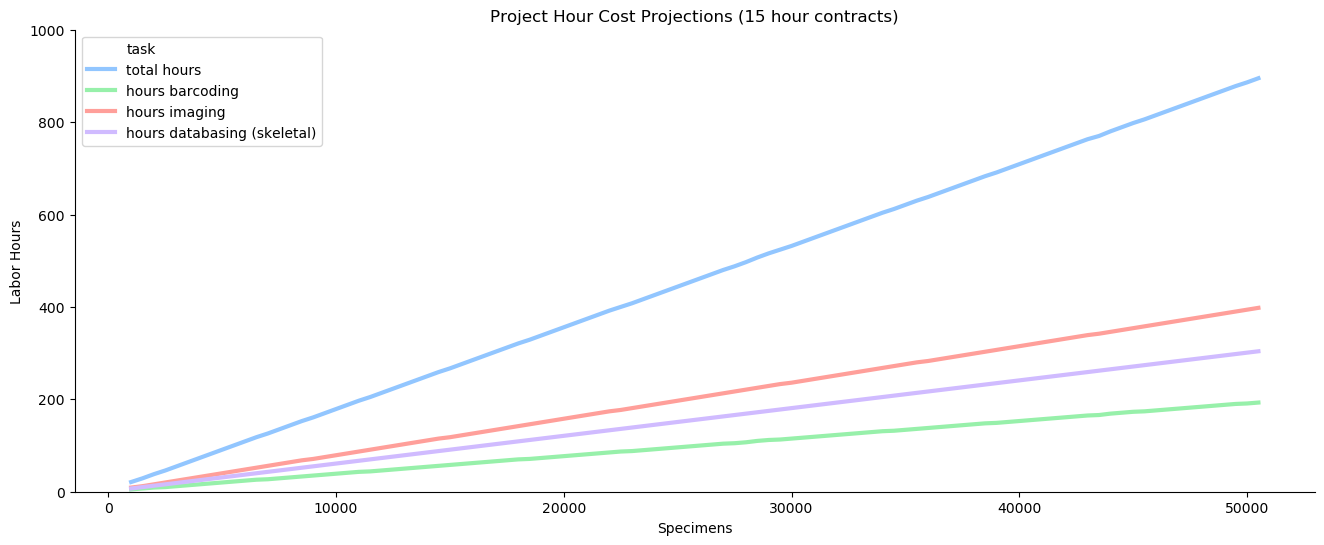

'collection size: Small, contract size: 45, estimated hours:788.0'

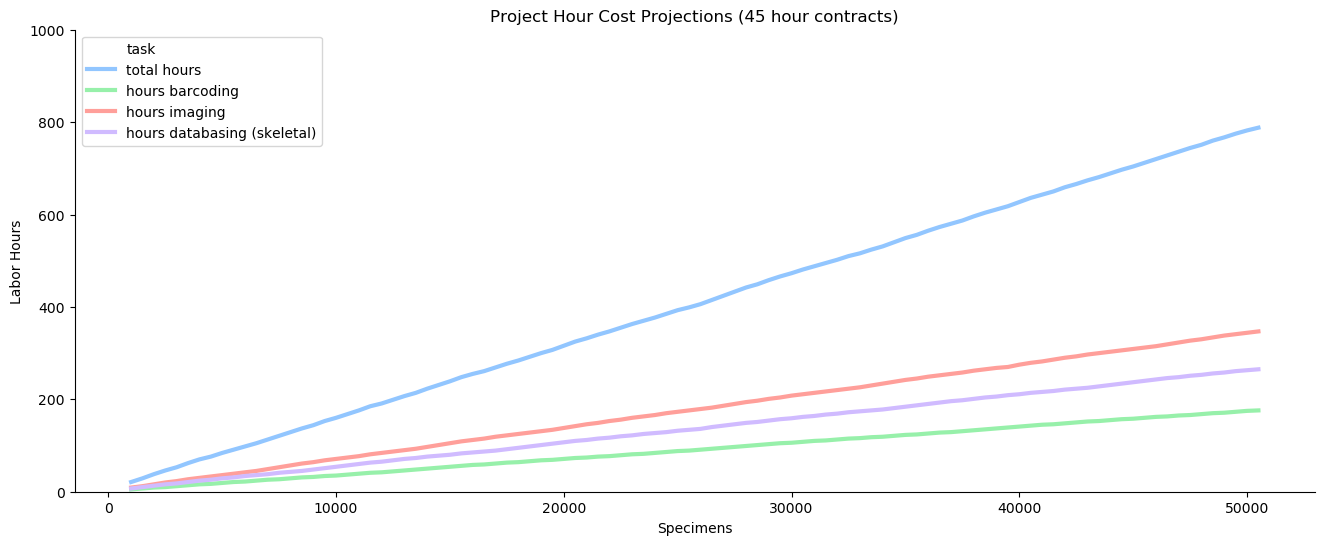

'collection size: Small, contract size: 135, estimated hours:682.0'

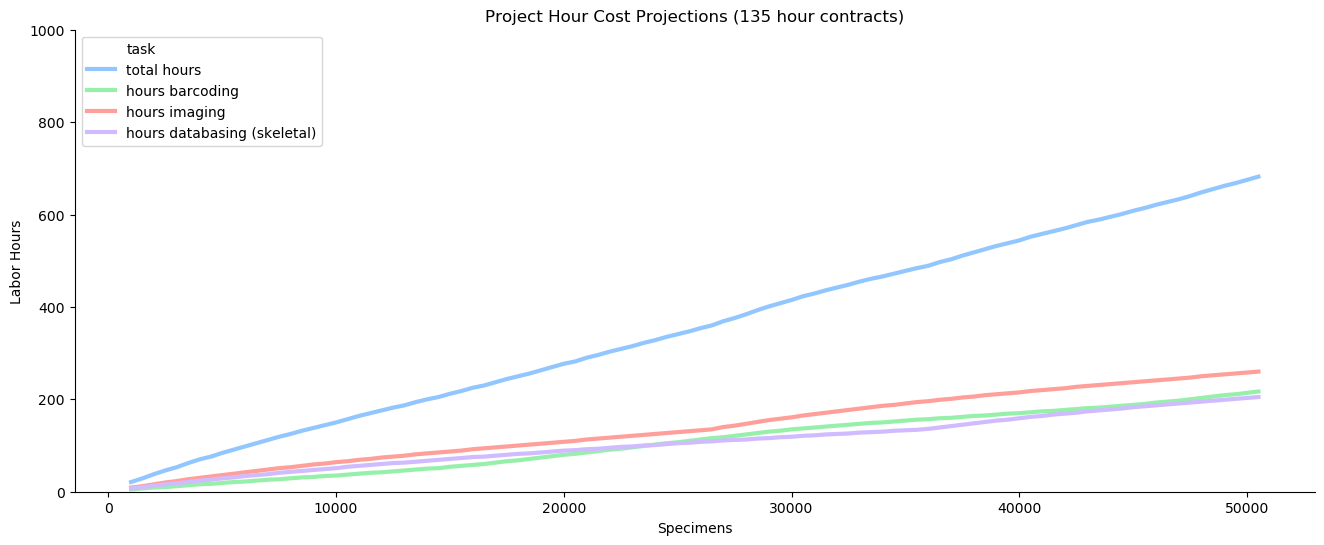

'collection size: Large, contract size: 15, estimated hours:8837.0'

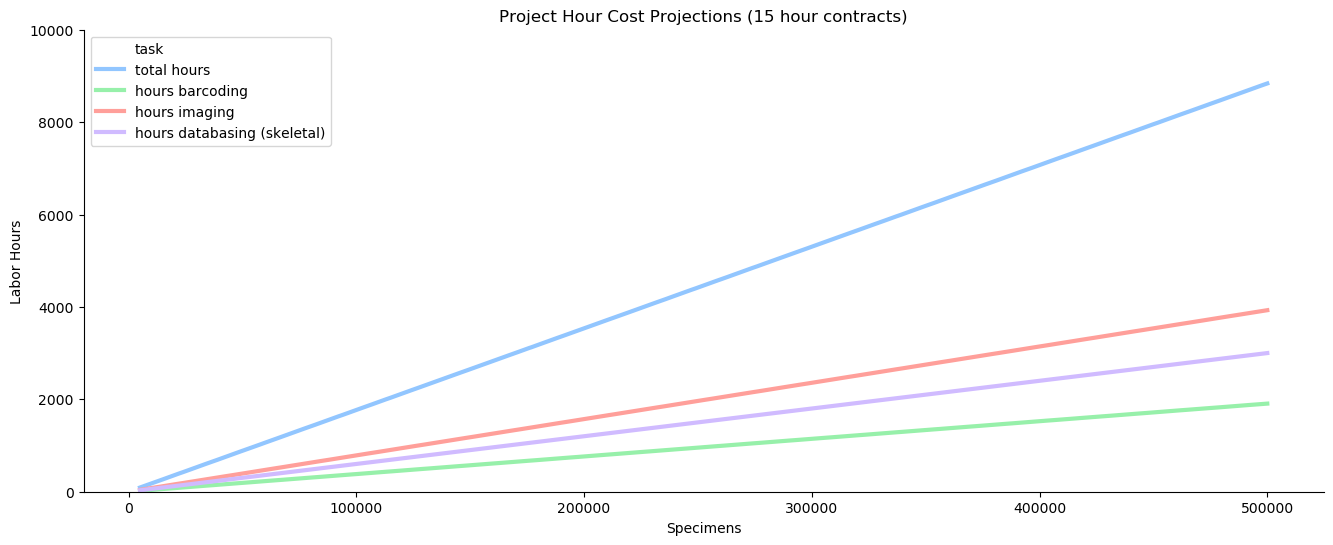

'collection size: Large, contract size: 45, estimated hours:7773.0'

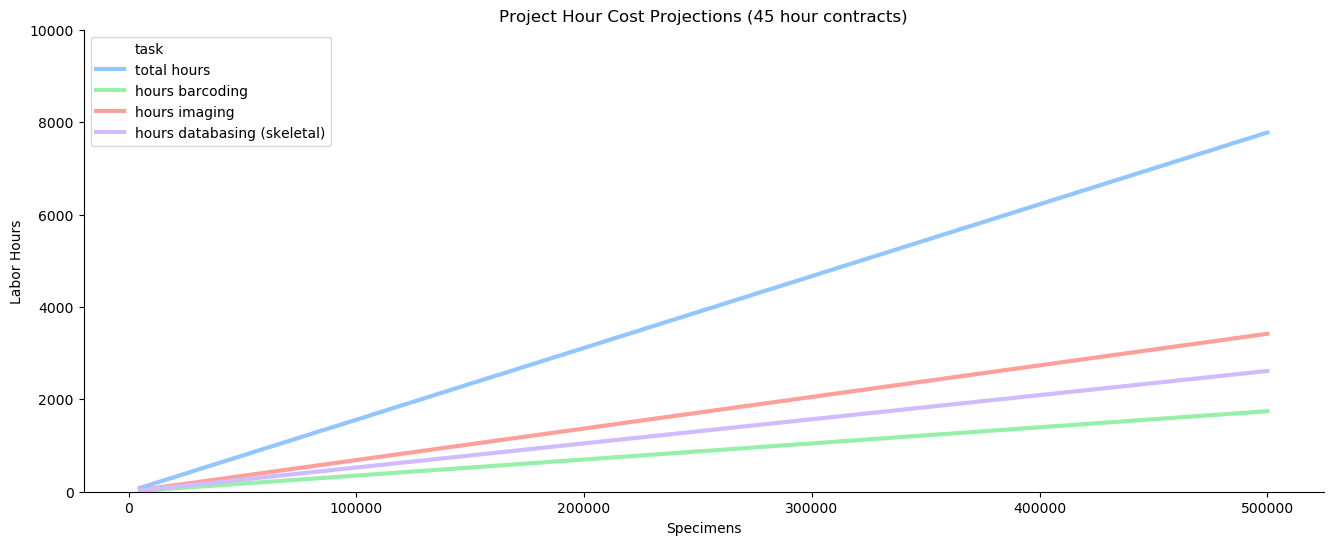

'collection size: Large, contract size: 135, estimated hours:6665.0'

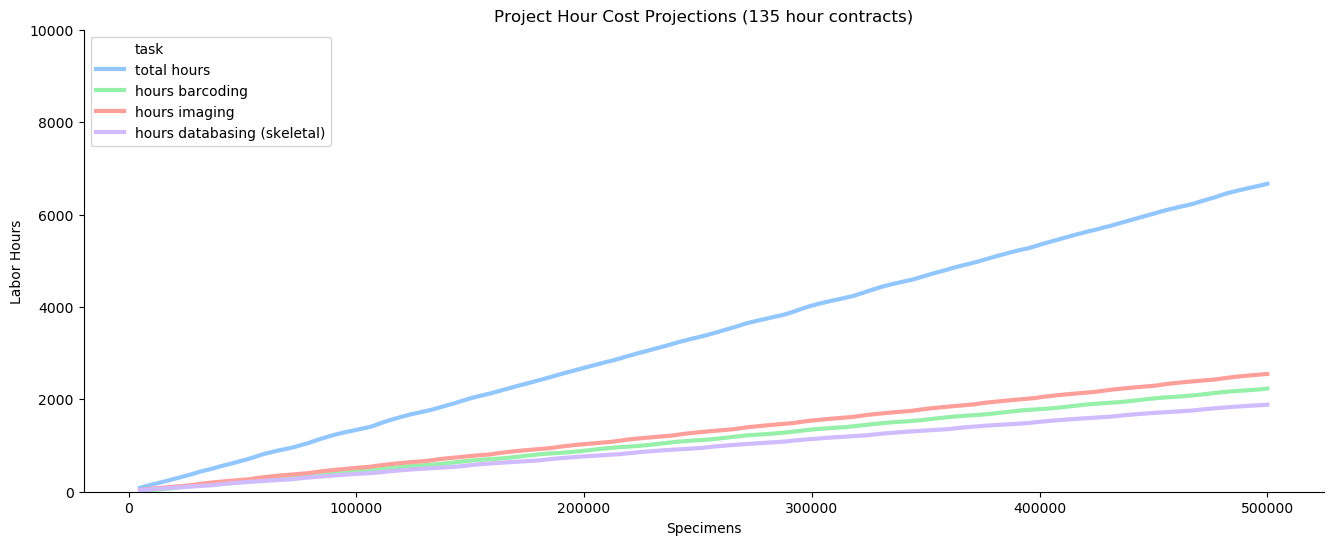

In [43]:
# for a small and large scale digitization projects
for scale in ['Small', 'Large']:
    # for both optimizing for bc and not
    #for bc_optimize in [True, False]:
    for bc_optimize in [False]:
        # for max contract hours of 15, 45 and 135
        for max_c in [15, 45, 135]:
            rename_map = {'b': 'hours barcoding',
                          'i': 'hours imaging',
                          'd': 'hours databasing (skeletal)',
                          'total hours': 'total hours'}

            simulated_df = pd.DataFrame()
            if scale == 'Small':
                sp_range = range(1000, 51000, 500)
                y_lim = 1000
            else:
                sp_range = range(5000, 501000, 1000)
                y_lim = 10000
            
            for x in sp_range:
                results, tot_hours = calcHoursReq(x, max_c, optimize_bc=bc_optimize)
                for task in ['total hours','b', 'i', 'd']:
                    taskName = rename_map[task]
                    taskTime = int(results.get(task, tot_hours))

                    task_results = {'specimens':int(x),
                                    'task':taskName,
                                    'hours':int(taskTime)
                                   }
                    simulated_df = simulated_df.append(task_results, ignore_index=True)
            
            # display the max values for each condition
            display(f'collection size: {scale}, contract size: {max_c}, estimated hours:{max(simulated_df["hours"])}')
            
            g = sns.lineplot(x="specimens", y="hours", data=simulated_df, hue="task")
            g.figure.set_size_inches(16,6)
            g.set_ylabel("Labor Hours")
            g.set_xlabel("Specimens")
            g.set_title(f'Project Hour Cost Projections ({max_c} hour contracts)')

            plt.ylim(0,y_lim)
            plt.setp(g.lines,linewidth=3)
            plt.legend(loc='upper left')
            #g.set_xscale('log')
            g.spines['top'].set_visible(False)
            g.spines['right'].set_visible(False)
            if bc_optimize:
                figName = f'{scale}_{max_c}_project_projection_bcOptimized.png'
            else:
                figName = f'{scale}_{max_c}_project_projection_NOT_bcOptimized.png'
            if to_save:
                plt.savefig(figName, dpi=300, quality=95, optimize=True, transparent=True)
            plt.show()

In [44]:
nSpec = 6000000
a, b = calcHoursReq(nSpec)
print(f'{nSpec} specimens would require a total of {b} hours')
for k,v in a.items():
    print(f'{k} takes {v} hours, {round((v/b)*100, 2)}% of the time')

6000000 specimens would require a total of 73755 hours
b takes 33302 hours, 45.15% of the time
i takes 25025 hours, 33.93% of the time
d takes 15428 hours, 20.92% of the time


In [45]:
nSpec = 200000
a, b = calcHoursReq(nSpec)
print(f'{nSpec} specimens would require a total of {b} hours')
for k,v in a.items():
    print(f'{k} takes {v} hours, {round((v/b)*100, 2)}% of the time')

200000 specimens would require a total of 2494 hours
b takes 1080 hours, 43.3% of the time
i takes 858 hours, 34.4% of the time
d takes 556 hours, 22.29% of the time


#### Compare to total THC data
Total THC Data has:
- BC: 
    - 20.7% 
    - 1233 hours
    - 263998 specimens
- Img:
    - 41.9%
    - 2494 hours
    - 308531 specimens
- DB:
    - 37.4%
    - 2226 hours
    - 345679 specimens
    
### Simulation is lowballing estimations
- The model is low balling the estimates, real world conditions per task took between 18% - 34% longer.
- This is likely an artifact of cleaning the data.
    - Post-cleaning now represents ideal "butt in seat" conditions and NOT real world conditions.

In [46]:
bcTime = calcHoursReq(263998,45,tasks= ['b'])[1]
print(f'Predicted barcoding 263,998 would take {bcTime} hours.')
# bc took us ~1233
print(1233 / bcTime)
imTime = calcHoursReq(308531,45,tasks= ['i'])[1]
print(f'Predicted imaging 308,531 would take {imTime} hours.')
# img took us ~2494
print(2494 / imTime)
dbTime = calcHoursReq(345679,45,tasks= ['d'])[1]
print(f'Predicted databasing 345,679 would take {dbTime} hours.')
# db took us ~2226
print(2226 / dbTime)

Predicted barcoding 263,998 would take 921 hours.
1.3387622149837133
Predicted imaging 308,531 would take 2110 hours.
1.1819905213270143
Predicted databasing 345,679 would take 1807 hours.
1.2318760376314333


In [47]:
totDigi = np.mean([263998, 308531, 345679]) # avg of all 3 tasks combined
totTime = calcHoursReq(totDigi,45)[1]
print(f'Predicted {totDigi}, for all tasks would take {totTime} hours.')
print(f'We used {round((5954 / totTime - 1) * 100, 1)}% more than predicted for overall project.')

Predicted 306069.3333333333, for all tasks would take 4762 hours.
We used 25.0% more than predicted for overall project.


#### Institution specific test data

In [48]:
def testInstitution(collectionName, contractTime = 40):
    print(f'Comparing {collectionName} to model:\n')
    iDF = df[df['Herbarium'] == collectionName].copy(deep=True)
    
    iDFtimeBC = round(iDF['Barcode application - number of minutes spent'].sum() / 60, 1)
    iDFspBC = iDF['Barcode application - number of specimens'].sum()

    bcTime = calcHoursReq(iDFspBC, contractTime,tasks= ['b'])[1]
    bcTime = round(bcTime,1)
    print(f'BARCODING {iDFspBC} specimens')
    print(f'{collectionName} used {iDFtimeBC} hours to BARCODE, model predicts {bcTime}')

    iDFtimeIm = round(iDF['Imaging - number of minutes spent'].sum() / 60, 1)
    iDFspIm = iDF['Imaging - number of specimens'].sum()

    imTime = calcHoursReq(iDFspIm, contractTime,tasks= ['i'])[1]
    imTime = round(imTime,1)
    print(f'IMAGING {iDFspIm} specimens.')
    print(f'{collectionName} used {iDFtimeIm} hours to IMAGE, model predicts {imTime}')
    
    iDFtimeDB = round(iDF['Skeletal data entry - number of minutes spent'].sum() / 60, 1)
    iDFspDB = iDF['Skeletal data entry - number of specimens'].sum()

    dbTime = calcHoursReq(iDFspDB, contractTime,tasks= ['d'])[1]
    dbTime = round(dbTime,1)
    print(f'DATABASING {iDFspDB} specimens')
    print(f'{collectionName} used {iDFtimeDB} hours to DATABASE, model predicts {dbTime}\n')
    
    totTimeUsed = sum([iDFtimeBC, iDFtimeIm, iDFtimeDB])
    totTimeEstimated = sum([bcTime, imTime, dbTime])
    totTimeDiff = round(totTimeUsed - totTimeEstimated, 1)

    print(f'used {totTimeUsed}')
    print(f'predicted {totTimeEstimated}')

    if totTimeDiff >= 0:
        print(f'The model UNDERestimated by {totTimeDiff} hours')
        ou = 'UNDER'

    else:
        print(f'The model OVERestimated by {totTimeDiff} hours')
        ou = 'OVER'
    
    pctError = -round(((totTimeDiff) / totTimeUsed) * 100 ,2)
    print(f'{pctError}% {ou}')
    print('\n')
    
    return pctError

In [49]:
totPctError = 0
collections = df['Herbarium'].unique()
for coll in collections:
    institutionPctError = testInstitution(coll, 90)
    totPctError += institutionPctError

if totPctError < 1:
    print(f'Treating all {len(collections)} institutions equally,  {abs(totPctError / len(collections))} UNDER estimated.')
else:
    print(f'Treating all {len(collections)} institutions equally,  {totPctError / len(collections)} OVER estimated.')

Comparing University of Tennessee Chattanooga (UCHT) to model:

BARCODING 35994.0 specimens
University of Tennessee Chattanooga (UCHT) used 162.7 hours to BARCODE, model predicts 140
IMAGING 32940.0 specimens.
University of Tennessee Chattanooga (UCHT) used 304.6 hours to IMAGE, model predicts 192
DATABASING 25739.0 specimens
University of Tennessee Chattanooga (UCHT) used 219.7 hours to DATABASE, model predicts 119

used 687.0
predicted 451
The model UNDERestimated by 236.0 hours
-34.35% UNDER


Comparing University of Tennessee Knoxville (TENN) to model:

BARCODING 122183.0 specimens
University of Tennessee Knoxville (TENN) used 465.5 hours to BARCODE, model predicts 493
IMAGING 133773.0 specimens.
University of Tennessee Knoxville (TENN) used 839.2 hours to IMAGE, model predicts 772
DATABASING 119559.0 specimens
University of Tennessee Knoxville (TENN) used 497.6 hours to DATABASE, model predicts 527

used 1802.3000000000002
predicted 1792
The model UNDERestimated by 10.3 hours
-0.5

### Compare this method to rates presented by Harris & Marsico (2017)

- based on: https://doi.org/10.3732/apps.1600125
- imaged 12,108 specimens @ 145 / hour with 5-6 students
- approximately 83.5 total hours imaging
    - Suggests between 13.9 - 16.7 hours retention time per student

In [50]:
for max_contract in [15, 45, 135]:
    AK_img_hrs = calcHoursReq(nSpecimens=12108, 
                              maxContract=max_contract, 
                              tasks = ['i'])[0].get('i')
    print(f'Using a max contract of: {max_contract}. Predicting {AK_img_hrs} hours necessary')
    print(f'    a difference of {AK_img_hrs - 83.5} from actual values.')
    
print("""\nUsing long contract durations (i.e., few total technicians),
    this method underestimates their numbers by 9.5 hours (~11%).""")

Using a max contract of: 15. Predicting 96 hours necessary
    a difference of 12.5 from actual values.
Using a max contract of: 45. Predicting 84 hours necessary
    a difference of 0.5 from actual values.
Using a max contract of: 135. Predicting 74 hours necessary
    a difference of -9.5 from actual values.

Using long contract durations (i.e., few total technicians),
    this method underestimates their numbers by 9.5 hours (~11%).


### Compare this method to estimation presented by Harris & Marsico (2017)
    - based on: https://doi.org/10.3732/apps.1600125
    - Harris & Marsico estimated 13 10-hour weeks for 1 person to image 20,000 specimens.
    - Converting this to 130 hours for 20,000 specimens.
    - Forcing "1" person by passing in a max contract value of 99999

In [51]:
max_contract=99999
AK_img_hrs = calcHoursReq(nSpecimens=20000, 
                          maxContract=max_contract, 
                          tasks = ['i'])[0].get('i')
print(f'Using a max contract of: {max_contract}. Predicting {AK_img_hrs} hours necessary')
print(f'    a difference of {AK_img_hrs - 130} or {((AK_img_hrs/130) - 1) * 100}% from actual values.')

print("""Our method underestimates their estimated values by ~17 hours (~13%)""")

Using a max contract of: 99999. Predicting 108 hours necessary
    a difference of -22 or -16.92307692307692% from actual values.
Our method underestimates their estimated values by ~17 hours (~13%)


#### Estimate a series of conditions to fill out Table 2

In [52]:
## Note, "ZCombined" is a lazy hack to get around double sorting complexity. 

duration_range = [[x]*4 for x in [15, 45, 135]]
duration_range = [item for sublist in duration_range for item in sublist]

table_df = pd.DataFrame({"Contract Duration":duration_range,
                         "Task":['Imaging','Databasing','Barcoding','ZCombined']*3,
                         "10,000":[0]*12,
                         "20,000":[0]*12,
                         "30,000":[0]*12,
                         "40,000":[0]*12,
                         "50,000":[0]*12,
                         "75,000":[0]*12,
                         "100,000":[0]*12,
                         "125,000":[0]*12,
                         "150,000":[0]*12,
                         "200,000":[0]*12,
                         "250,000":[0]*12,
                         "300,000":[0]*12,
                         "500,000":[0]*12})

for contract_duration in duration_range:
    
    contract_cond = table_df["Contract Duration"] == contract_duration
    
    for n_specimens in ["10,000", "20,000", "30,000", "40,000", "50,000",
                        "75,000", "100,000", "125,000", "150,000", "200,000",
                        "250,000", "300,000", "500,000"]:
        int_n_specimens = int(n_specimens.replace(',', ''))
        task_hours, tot_hours = calcHoursReq(nSpecimens=int_n_specimens,
                                             maxContract=contract_duration)
        for taskName in ['Imaging','Databasing','Barcoding','ZCombined']:
            taskLetter = taskName[0].lower()
            taskTime = int(task_hours.get(taskLetter, tot_hours))

            task_cond = table_df["Task"] == taskName
            
            table_df.loc[contract_cond & task_cond, n_specimens] = taskTime
            
#table_df = table_df.set_index("Contract Duration")
table_df = table_df.sort_values(["Contract Duration", "Task"])
table_df.loc[table_df['Task']=="ZCombined", "Task"] = "Combined"
table_df

,Contract Duration,Task,"10,000","20,000","30,000","40,000","50,000","75,000","100,000","125,000","150,000","200,000","250,000","300,000","500,000"
2,15,Barcoding,39,77,115,153,191,287,382,477,573,763,954,1145,1907
1,15,Databasing,61,121,181,241,301,451,601,751,901,1201,1501,1801,3001
0,15,Imaging,79,158,236,315,394,590,787,983,1179,1572,1965,2358,3929
3,15,Combined,179,356,532,709,886,1328,1770,2211,2653,3536,4420,5304,8837
6,45,Barcoding,35,71,106,141,175,262,349,436,524,698,873,1047,1743
5,45,Databasing,54,107,159,211,263,394,525,655,786,1047,1306,1568,2612
4,45,Imaging,71,138,208,275,344,515,685,855,1027,1369,1709,2053,3418
7,45,Combined,160,316,473,627,782,1171,1559,1946,2337,3114,3888,4668,7773
10,135,Barcoding,35,80,135,170,214,323,440,558,673,887,1114,1346,2233
9,135,Databasing,51,89,119,159,203,289,384,484,575,765,942,1142,1883


In [53]:
duration_range = [[x]*4 for x in range(10, 110, 10)]
duration_range = [item for sublist in duration_range for item in sublist]
len(duration_range)

40

#### Estimate a series of equally spaced conditions for horizontal / vertical comparison

In [54]:
## Note, "ZCombined" is a lazy hack to get around double sorting complexity. 

duration_range = [[x]*4 for x in range(10, 110, 10)]
duration_range = [item for sublist in duration_range for item in sublist]

table_df = pd.DataFrame({"Contract Duration":duration_range,
                         "Task":['Imaging','Databasing','Barcoding','ZCombined']*10,
                         "10,000":[0]*40,
                         "20,000":[0]*40,
                         "30,000":[0]*40,
                         "40,000":[0]*40,
                         "50,000":[0]*40,
                         "60,000":[0]*40,
                         "70,000":[0]*40,
                         "80,000":[0]*40,
                         "90,000":[0]*40,
                         "100,000":[0]*40})
for contract_duration in [x for x in duration_range]:
    
    contract_cond = table_df["Contract Duration"] == contract_duration
    
    for n_specimens in ["10,000", "20,000", "30,000", "40,000", "50,000",
                        "60,000", "70,000", "80,000", "90,000", "100,000"]:
        int_n_specimens = int(n_specimens.replace(',', ''))
        task_hours, tot_hours = calcHoursReq(nSpecimens=int_n_specimens,
                                             maxContract=contract_duration)
        for taskName in ['Imaging','Databasing','Barcoding','ZCombined']:
            taskLetter = taskName[0].lower()
            taskTime = int(task_hours.get(taskLetter, tot_hours))

            task_cond = table_df["Task"] == taskName
            
            table_df.loc[contract_cond & task_cond, n_specimens] = taskTime
            
#table_df = table_df.set_index("Contract Duration")
table_df = table_df.sort_values(["Contract Duration", "Task"])
table_df.loc[table_df['Task']=="ZCombined", "Task"] = "Combined"
table_df = table_df.loc[table_df['Task'] == 'Combined']
table_df

,Contract Duration,Task,"10,000","20,000","30,000","40,000","50,000","60,000","70,000","80,000","90,000","100,000"
3,10,Combined,183,366,547,729,911,1093,1274,1456,1638,1819
7,20,Combined,174,347,519,692,864,1034,1207,1379,1552,1725
11,30,Combined,169,332,498,662,826,989,1153,1319,1483,1648
15,40,Combined,163,322,478,637,796,953,1112,1268,1426,1586
19,50,Combined,157,311,463,618,770,923,1077,1230,1382,1538
23,60,Combined,152,307,454,605,754,902,1054,1202,1353,1502
27,70,Combined,150,303,442,598,742,888,1032,1181,1322,1474
31,80,Combined,150,300,439,584,725,879,1013,1162,1304,1455
35,90,Combined,150,290,432,572,721,850,1008,1134,1290,1423
39,100,Combined,150,284,431,563,708,846,980,1129,1255,1410


#### Quick test of outputs of calcHours Req function
    - given 20,000 specimens at a max contract duration of 15 hours.

In [55]:
calcHoursReq(nSpecimens=20000, maxContract=15)

({'b': 77, 'i': 158, 'd': 121}, 356)